# **A. Import Libraries**

In [1]:
# Import Libraries
import os, shutil, random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf

# Import Module
from PIL import Image
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input

# **B. Feature Engineering**

In [5]:
# Define path
main_path = 'chicken_disease'
train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'test')
val_path = os.path.join(main_path, 'validation')

In [6]:
# Check how many data in `train_path` and `test_path`
def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')
print('Validation Path')
check_path(val_path)

Train Path
Total Data - Coccidiosis : 1980
Total Data - Healthy : 1923
Total Data - New Castle Disease : 505
Total Data - Salmonella : 2100

Test Path
Total Data - Coccidiosis : 248
Total Data - Healthy : 241
Total Data - New Castle Disease : 29
Total Data - Salmonella : 263

Validation Path
Total Data - Coccidiosis : 248
Total Data - Healthy : 240
Total Data - New Castle Disease : 28
Total Data - Salmonella : 262


---

## **B.1 - Preprocessing with Data Augmentation**

In [7]:
# Define hyperparameters
img_height= 220
img_width= 220
batch_size= 64

In [8]:
# Path dataset hasil split
base_path = "chicken_disease"
train_path = os.path.join(base_path, "train")
val_path   = os.path.join(base_path, "validation")
test_path  = os.path.join(base_path, "test")

# Data augmentation untuk train
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Hanya normalisasi untuk val dan test
val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Train generator
train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode="binary",
    batch_size=batch_size,
    shuffle=True,
    seed=2
)

# Val generator
val_set = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode="binary",
    batch_size=batch_size,
    shuffle=True,
    seed=2
)

# Test generator
test_set = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode="binary",
    batch_size=batch_size,
    shuffle=False
)


Found 6508 images belonging to 4 classes.
Found 778 images belonging to 4 classes.
Found 781 images belonging to 4 classes.


In [9]:
# Show labels
train_set.class_indices

{'Coccidiosis': 0, 'Healthy': 1, 'New Castle Disease': 2, 'Salmonella': 3}

---

# **C. CNN Training**

## **C.1 - Model Definition**

In [16]:
# Clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [17]:
# Create Sequential API model
model_aug = Sequential()
model_aug.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,1)))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(64, (3,3), activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(128, (3,3),activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(128, activation='relu'))
model_aug.add(Dense(4, activation='softmax'))

# Compile
model_aug.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_aug.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 218, 218, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 107, 107, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,240,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,333,316 (39.42 MB)

 Trainable params: 10,333,316 (39.42 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Plot layers
tf.keras.utils.plot_model(model_aug, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


---

## **C.2 - Model Training**

In [19]:
# Train the model
history_aug = model_aug.fit(train_set, epochs=50, validation_data=val_set, batch_size=batch_size)

Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.4104 - loss: 1.2791 - val_accuracy: 0.7365 - val_loss: 0.8017
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.6713 - loss: 0.8515 - val_accuracy: 0.7596 - val_loss: 0.6470
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.7197 - loss: 0.7309 - val_accuracy: 0.8046 - val_loss: 0.5171
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.7348 - loss: 0.6916 - val_accuracy: 0.8008 - val_loss: 0.5622
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.7522 - loss: 0.6736 - val_accuracy: 0.8162 - val_loss: 0.5078
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.7583 - loss: 0.6551 - val_accuracy: 0.8111 - val_loss: 0.5137
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.7751 - loss: 0.6028 - val_accuracy: 0.8111 - val_loss: 0.5181
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.7653 - loss: 0.6208 - val_accu

---

## **C.3 - Model Evaluation**

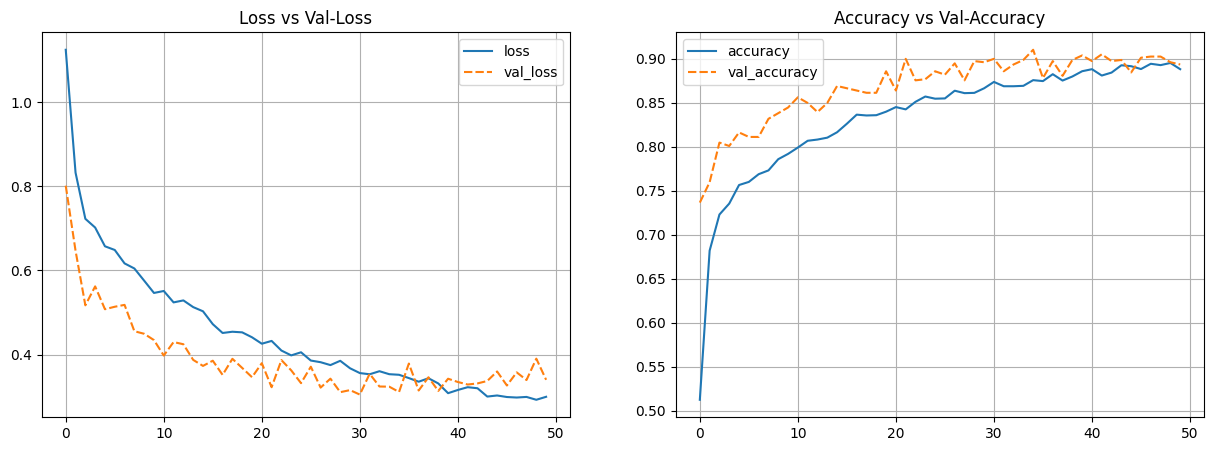

In [20]:
# Plot training results
history_aug_df = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

c:\Users\USER\miniconda3\envs\h8_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 430ms/step


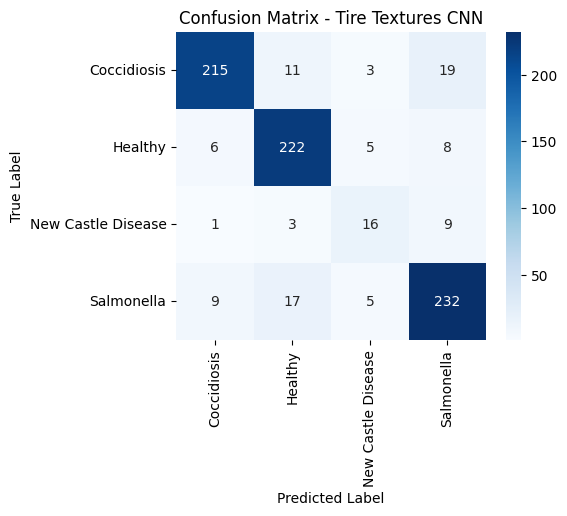

Classification Report:

                    precision    recall  f1-score   support

       Coccidiosis       0.93      0.87      0.90       248
           Healthy       0.88      0.92      0.90       241
New Castle Disease       0.55      0.55      0.55        29
        Salmonella       0.87      0.88      0.87       263

          accuracy                           0.88       781
         macro avg       0.81      0.81      0.81       781
      weighted avg       0.88      0.88      0.88       781



In [21]:
# Prediksi probabilitas
y_pred_prob_aug = model_aug.predict(test_set)

# Karena binary classification, kita cek dulu bentuk output
if y_pred_prob_aug.shape[1] == 1:
    # Kalau output 1 neuron sigmoid → threshold 0.5
    y_pred_class_aug = (y_pred_prob_aug > 0.9).astype("int32").ravel()
else:
    # Kalau output softmax → ambil argmax
    y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=-1)

# True labels dari test set
y_true = test_set.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_class_aug)
labels = list(train_set.class_indices.keys())

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Tire Textures CNN")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_class_aug, target_names=labels))


---

## **C.4 - Model Saving**

In [22]:
# Model summary
model_aug.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 218, 218, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 107, 107, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,240,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,999,950 (118.26 MB)

 Trainable params: 10,333,316 (39.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,666,634 (78.84 MB)

In [23]:
# Freeze model
model_aug.trainable = False
model_aug.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 218, 218, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 107, 107, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,240,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,999,950 (118.26 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,333,316 (39.42 MB)

 Optimizer params: 20,666,634 (78.84 MB)

In [24]:
# Save CNN model
model_aug.save('model_aug_ver6.keras', include_optimizer=True)